## Reading HATS: generic parquet readers

This notebooks is a follow-up on [readers.ipynb](../parquet_in_root/readers.ipynb), to test parquet reading when the parquet files are in a dedicated directory (here called `data`).

In [1]:
small_sky_order1_path = "small_sky_order1"
small_sky_order1_Npix_part_path = "small_sky_order1_Npix_part"

## PyArrow

Let's start with PyArrow, considering it's the engine behind LSDB.

In [2]:
import pyarrow.parquet as pq
import pyarrow.dataset as pds

First attempt at reading the catalog, works like a charm. We don't need to worry about ignoring non-parquet files.

In [3]:
dataset = pds.dataset(f"{small_sky_order1_path}/data", format="parquet")
print(dataset.count_rows())
dataset.head(10)

131


pyarrow.Table
id: int64
ra: double
dec: double
ra_error: int64
dec_error: int64
Norder: uint8
Dir: uint64
Npix: uint64
_healpix_29: int64
----
id: [[707,792,811,723,826,750,771,734,738,772]]
ra: [[308.5,320.5,315.5,315.5,335.5,338.5,348.5,348.5,345.5,348.5]]
dec: [[-69.5,-69.5,-68.5,-68.5,-69.5,-67.5,-67.5,-66.5,-64.5,-64.5]]
ra_error: [[0,0,0,0,0,0,0,0,0,0]]
dec_error: [[0,0,0,0,0,0,0,0,0,0]]
Norder: [[1,1,1,1,1,1,1,1,1,1]]
Dir: [[0,0,0,0,0,0,0,0,0,0]]
Npix: [[44,44,44,44,44,44,44,44,44,44]]
_healpix_29: [[3187422220182231470,3187796123455121090,3188300701662669945,3188300701662669945,3192670279995812269,3192995164288065358,3194102393993053262,3195678697494500888,3196676706683767043,3196723640945762243]]

By default the files are not mapped to the correct partitions:

In [4]:
[f for f in dataset.get_fragments()]

[<pyarrow.dataset.ParquetFileFragment path=small_sky_order1/data/Norder=1/Dir=0/Npix=44.parquet>,
 <pyarrow.dataset.ParquetFileFragment path=small_sky_order1/data/Norder=1/Dir=0/Npix=45.parquet>,
 <pyarrow.dataset.ParquetFileFragment path=small_sky_order1/data/Norder=1/Dir=0/Npix=46.parquet>,
 <pyarrow.dataset.ParquetFileFragment path=small_sky_order1/data/Norder=1/Dir=0/Npix=47.parquet>]

Let's try forcing the hive partitioning:

In [5]:
dataset = pds.dataset(
    f"{small_sky_order1_path}/data",
    format="parquet",
    partitioning="hive",
)

ArrowTypeError: Unable to merge: Field Norder has incompatible types: uint8 vs int32

The hive keys are not being correctly cast for the `Norder` field. We need to provide the catalog schema for this to work:

In [6]:
dataset = pds.dataset(
    f"{small_sky_order1_path}/data",
    format="parquet",
    partitioning="hive",
    schema=pq.read_metadata(f"{small_sky_order1_path}/data/_common_metadata").schema.to_arrow_schema(), 
)
print(dataset.count_rows())
dataset.head(10)

131


pyarrow.Table
id: int64
ra: double
dec: double
ra_error: int64
dec_error: int64
Norder: uint8
Dir: uint64
Npix: uint64
_healpix_29: int64
----
id: [[707,792,811,723,826,750,771,734,738,772]]
ra: [[308.5,320.5,315.5,315.5,335.5,338.5,348.5,348.5,345.5,348.5]]
dec: [[-69.5,-69.5,-68.5,-68.5,-69.5,-67.5,-67.5,-66.5,-64.5,-64.5]]
ra_error: [[0,0,0,0,0,0,0,0,0,0]]
dec_error: [[0,0,0,0,0,0,0,0,0,0]]
Norder: [[1,1,1,1,1,1,1,1,1,1]]
Dir: [[0,0,0,0,0,0,0,0,0,0]]
Npix: [[44,44,44,44,44,44,44,44,44,44]]
_healpix_29: [[3187422220182231470,3187796123455121090,3188300701662669945,3188300701662669945,3192670279995812269,3192995164288065358,3194102393993053262,3195678697494500888,3196676706683767043,3196723640945762243]]

In [7]:
[f for f in dataset.get_fragments()]

[<pyarrow.dataset.ParquetFileFragment path=small_sky_order1/data/Norder=1/Dir=0/Npix=44.parquet partition=[Norder=1, Dir=0]>,
 <pyarrow.dataset.ParquetFileFragment path=small_sky_order1/data/Norder=1/Dir=0/Npix=45.parquet partition=[Norder=1, Dir=0]>,
 <pyarrow.dataset.ParquetFileFragment path=small_sky_order1/data/Norder=1/Dir=0/Npix=46.parquet partition=[Norder=1, Dir=0]>,
 <pyarrow.dataset.ParquetFileFragment path=small_sky_order1/data/Norder=1/Dir=0/Npix=47.parquet partition=[Norder=1, Dir=0]>]

What if we have a sharded `Npix` directory? Should work without any hassle for all readers.

In [8]:
dataset = pds.dataset(
    f"{small_sky_order1_Npix_part_path}/data",
    format="parquet",
    partitioning="hive",
    schema=pq.read_metadata(f"{small_sky_order1_Npix_part_path}/data/_common_metadata").schema.to_arrow_schema(),
)
print(dataset.count_rows())
dataset.head(10)

131


pyarrow.Table
id: int64
ra: double
dec: double
ra_error: int64
dec_error: int64
Norder: uint8
Dir: uint64
Npix: uint64
_healpix_29: int64
----
id: [[707,792,811,723,826,750,771,734,738,772]]
ra: [[308.5,320.5,315.5,315.5,335.5,338.5,348.5,348.5,345.5,348.5]]
dec: [[-69.5,-69.5,-68.5,-68.5,-69.5,-67.5,-67.5,-66.5,-64.5,-64.5]]
ra_error: [[0,0,0,0,0,0,0,0,0,0]]
dec_error: [[0,0,0,0,0,0,0,0,0,0]]
Norder: [[1,1,1,1,1,1,1,1,1,1]]
Dir: [[0,0,0,0,0,0,0,0,0,0]]
Npix: [[44,44,44,44,44,44,44,44,44,44]]
_healpix_29: [[3187422220182231470,3187796123455121090,3188300701662669945,3188300701662669945,3192670279995812269,3192995164288065358,3194102393993053262,3195678697494500888,3196676706683767043,3196723640945762243]]

Now the fragment partitions include information about the respective Npix:

In [9]:
[f for f in dataset.get_fragments()]

[<pyarrow.dataset.ParquetFileFragment path=small_sky_order1_Npix_part/data/Norder=1/Dir=0/Npix=44/part_0.parquet partition=[Norder=1, Npix=44, Dir=0]>,
 <pyarrow.dataset.ParquetFileFragment path=small_sky_order1_Npix_part/data/Norder=1/Dir=0/Npix=45/part_0.parquet partition=[Norder=1, Npix=45, Dir=0]>,
 <pyarrow.dataset.ParquetFileFragment path=small_sky_order1_Npix_part/data/Norder=1/Dir=0/Npix=46/part_0.parquet partition=[Norder=1, Npix=46, Dir=0]>,
 <pyarrow.dataset.ParquetFileFragment path=small_sky_order1_Npix_part/data/Norder=1/Dir=0/Npix=47/part_0.parquet partition=[Norder=1, Npix=47, Dir=0]>]

Another test we can run is to read catalogs from the cloud (e.g. via HTTPS try to load erosita on Epyc):

In [10]:
import fsspec

https_fs = fsspec.filesystem('https')

erosita_https_path = "https://data.lsdb.io/unstable/erosita_test"

dataset = pds.dataset(
    f"{erosita_https_path}/data",
    format="parquet",
    partitioning="hive",
    # We need to provide a filesystem, otherwise it's not correctly inferred.
    filesystem=https_fs,
    schema=pq.read_metadata(f"{erosita_https_path}/data/_common_metadata", filesystem=https_fs).schema.to_arrow_schema(),
)
print(dataset.count_rows())

ArrowInvalid: Could not open Parquet input source 'https://data.lsdb.io/unstable/erosita_test/data': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.

The `pds.dataset` API doesn't handle remote paths well, but `pds.parquet_dataset` does!

In [11]:
dataset = pds.parquet_dataset(
    metadata_path=f"{erosita_https_path}/data/_metadata",
    partitioning='hive',
    filesystem=https_fs,
    schema=pq.read_metadata(f"{erosita_https_path}/data/_common_metadata", filesystem=https_fs).schema.to_arrow_schema()
)

In [12]:
dataset.head(10)

pyarrow.Table
IAUNAME: binary
DETUID: binary
SKYTILE: int32
ID_SRC: int32
UID: int64
UID_Hard: int64
ID_CLUSTER: int32
RA: double
DEC: double
RA_RAW: double
DEC_RAW: double
RA_LOWERR: float
RA_UPERR: float
DEC_LOWERR: float
DEC_UPERR: float
POS_ERR: float
RADEC_ERR: float
LII: double
BII: double
ELON: double
ELAT: double
MJD: float
MJD_MIN: float
MJD_MAX: float
EXT: float
EXT_ERR: float
EXT_LOWERR: float
EXT_UPERR: float
EXT_LIKE: float
DET_LIKE_0: float
ML_CTS_1: float
ML_CTS_ERR_1: float
ML_CTS_LOWERR_1: float
ML_CTS_UPERR_1: float
ML_RATE_1: float
ML_RATE_ERR_1: float
ML_RATE_LOWERR_1: float
ML_RATE_UPERR_1: float
ML_FLUX_1: float
ML_FLUX_ERR_1: float
ML_FLUX_LOWERR_1: float
ML_FLUX_UPERR_1: float
ML_BKG_1: float
ML_EXP_1: float
ML_EEF_1: float
APE_CTS_1: int32
APE_BKG_1: float
APE_EXP_1: float
APE_RADIUS_1: float
APE_POIS_1: float
DET_LIKE_P1: float
ML_CTS_P1: float
ML_CTS_ERR_P1: float
ML_CTS_LOWERR_P1: float
ML_CTS_UPERR_P1: float
ML_RATE_P1: float
ML_RATE_ERR_P1: float
ML_RATE_L

## DuckDB

DuckDB is DB-like API which also allows access to data stored in parquet.

In [13]:
import duckdb

"""
We need to construct a glob pattern to the target parquet files. This seems
to be the only way to avoid non-parquet reads as well; I haven't found a 
solution to ignore prefixes for HATS-specific files at the root.

By default:
- hive_partitioning = true
- hive_types_autocast = true (hive types are automatically detected)
"""
con = duckdb.connect()
query = f"SELECT * FROM read_parquet(['{small_sky_order1_path}/data/**/*.parquet'])" 
dataset = con.execute(query).df() # Can also we .fetchall() to get Python objects
print(dataset.dtypes)
dataset.head(10)

id               int64
ra             float64
dec            float64
ra_error         int64
dec_error        int64
Norder           int64
Dir              int64
Npix            uint64
_healpix_29      int64
dtype: object


,id,ra,dec,ra_error,dec_error,Norder,Dir,Npix,_healpix_29
0,707,308.5,-69.5,0,0,1,0,44,3187422220182231470
1,792,320.5,-69.5,0,0,1,0,44,3187796123455121090
2,811,315.5,-68.5,0,0,1,0,44,3188300701662669945
3,723,315.5,-68.5,0,0,1,0,44,3188300701662669945
4,826,335.5,-69.5,0,0,1,0,44,3192670279995812269
5,750,338.5,-67.5,0,0,1,0,44,3192995164288065358
6,771,348.5,-67.5,0,0,1,0,44,3194102393993053262
7,734,348.5,-66.5,0,0,1,0,44,3195678697494500888
8,738,345.5,-64.5,0,0,1,0,44,3196676706683767043
9,772,348.5,-64.5,0,0,1,0,44,3196723640945762243


The types for the hive parameters were not inferred correctly (they were autocast to signed int64).

In [14]:
# We should provide a list of paths where the `_common_metadata`, which contains the catalog schema, is present
files = [f'{small_sky_order1_path}/data/**/*.parquet', f'{small_sky_order1_path}/data/_common_metadata']
query = f"SELECT * FROM read_parquet({files})"
dataset = con.execute(query).df()
dataset.dtypes

id               int64
ra             float64
dec            float64
ra_error         int64
dec_error        int64
Norder           uint8
Dir             uint64
Npix            uint64
_healpix_29      int64
dtype: object

In [15]:
# Or we can provide the hive_types manually
query = f"SELECT * FROM read_parquet('{small_sky_order1_path}/data/**/*.parquet', hive_types = {{'Norder': np.uint64, 'Dir': np.uint64}})" 
dataset = con.execute(query).df()
dataset.dtypes

id               int64
ra             float64
dec            float64
ra_error         int64
dec_error        int64
Norder          uint64
Dir             uint64
Npix            uint64
_healpix_29      int64
dtype: object

If we want to have a look at the data types, we can always just read the schema from the metadata directly:

In [16]:
schema_query = f"SELECT * FROM parquet_schema('{small_sky_order1_path}/data/_common_metadata')"
schema = con.execute(schema_query).df()
schema

,file_name,name,type,type_length,repetition_type,num_children,converted_type,scale,precision,field_id,logical_type
0,small_sky_order1/data/_common_metadata,schema,None,None,REQUIRED,9.0,None,NaN,NaN,NaN,None
1,small_sky_order1/data/_common_metadata,id,INT64,None,OPTIONAL,NaN,None,NaN,NaN,NaN,None
2,small_sky_order1/data/_common_metadata,ra,DOUBLE,None,OPTIONAL,NaN,None,NaN,NaN,NaN,None
3,small_sky_order1/data/_common_metadata,dec,DOUBLE,None,OPTIONAL,NaN,None,NaN,NaN,NaN,None
4,small_sky_order1/data/_common_metadata,ra_error,INT64,None,OPTIONAL,NaN,None,NaN,NaN,NaN,None
5,small_sky_order1/data/_common_metadata,dec_error,INT64,None,OPTIONAL,NaN,None,NaN,NaN,NaN,None
6,small_sky_order1/data/_common_metadata,Norder,INT32,None,OPTIONAL,NaN,UINT_8,NaN,NaN,NaN,"IntType(bitWidth=, isSigned=0)"
7,small_sky_order1/data/_common_metadata,Dir,INT64,None,OPTIONAL,NaN,UINT_64,NaN,NaN,NaN,"IntType(bitWidth=@, isSigned=0)"
8,small_sky_order1/data/_common_metadata,Npix,INT64,None,OPTIONAL,NaN,UINT_64,NaN,NaN,NaN,"IntType(bitWidth=@, isSigned=0)"
9,small_sky_order1/data/_common_metadata,_healpix_29,INT64,None,OPTIONAL,NaN,None,NaN,NaN,NaN,None


DuckDB supports filter pushdown which enables selective reading of files according to the hive partition parameters. Filtering on non-hive parameters should still require reading files in their entirety.

```python
# To enable query profiling set the following PRAGMA instructions 
con.execute("PRAGMA enable_profiling = json;")
con.execute("PRAGMA profiling_output = 'query_profile.json';")
```

In [17]:
filter_query = f"SELECT * FROM read_parquet({files}) WHERE ra >= 320 and ra < 330"
con.execute(filter_query).fetchall()

[(792, 320.5, -69.5, 0, 0, 1, 0, 44, 3187796123455121090),
 (733, 329.5, -65.5, 0, 0, 1, 0, 44, 3199487976390127826),
 (804, 322.5, -66.5, 0, 0, 1, 0, 44, 3200256676290451752),
 (747, 327.5, -61.5, 0, 0, 1, 0, 44, 3204516948860795443),
 (730, 322.5, -61.5, 0, 0, 1, 0, 44, 3226002888984791684),
 (758, 325.5, -53.5, 0, 0, 1, 0, 44, 3231100210201107330),
 (780, 326.5, -52.5, 0, 0, 1, 0, 44, 3231184305677168587),
 (775, 321.5, -54.5, 0, 0, 1, 0, 44, 3231700866781904205),
 (760, 320.5, -53.5, 0, 0, 1, 0, 44, 3231878325196547826),
 (787, 320.5, -47.5, 0, 0, 1, 0, 44, 3239635329517312051),
 (762, 327.5, -51.5, 0, 0, 1, 0, 45, 3279291389443808596),
 (728, 328.5, -47.5, 0, 0, 1, 0, 45, 3280519485071506911),
 (704, 326.5, -45.5, 0, 0, 1, 0, 45, 3282636638232395130),
 (724, 323.5, -41.5, 0, 0, 1, 0, 45, 3289601756303010980),
 (808, 320.5, -40.5, 0, 0, 1, 0, 45, 3291070806176264467),
 (761, 329.5, -29.5, 0, 0, 1, 0, 45, 3308757303244427140),
 (796, 320.5, -33.5, 0, 0, 1, 0, 47, 3391463069396352355

Let's try to read a catalog with `Npix` partitioned directories:

In [18]:
# No issues, as expected
files = [f'{small_sky_order1_Npix_part_path}/data/**/*.parquet', f'{small_sky_order1_Npix_part_path}/data/_common_metadata']
query = f"SELECT * FROM read_parquet({files})" 
dataset = con.execute(query).df()
dataset

,id,ra,dec,ra_error,dec_error,Norder,Dir,Npix,_healpix_29
0,707,308.5,-69.5,0,0,1,0,44,3187422220182231470
1,792,320.5,-69.5,0,0,1,0,44,3187796123455121090
2,811,315.5,-68.5,0,0,1,0,44,3188300701662669945
3,723,315.5,-68.5,0,0,1,0,44,3188300701662669945
4,826,335.5,-69.5,0,0,1,0,44,3192670279995812269
...,...,...,...,...,...,...,...,...,...
126,791,312.5,-28.5,0,0,1,0,47,3397804200316730633
127,824,305.5,-28.5,0,0,1,0,47,3399000453069933430
128,702,310.5,-27.5,0,0,1,0,47,3399532867186255393
129,767,314.5,-29.5,0,0,1,0,47,3400255793565258227


## Polars

Polars is a very efficient library for data processing in Rust.

In [19]:
import polars as pl

"""
Polars allows for lazy loading with `scan_parquet`.

- We need to construct the glob pattern for parquet (there's no way of ignoring non-parquet files at root);
- We can specify the schema argument as a dictionary.
- We can pass a storage_options dictionary, if needed.
"""
lazy_df = pl.scan_parquet(f"{small_sky_order1_Npix_part_path}/data/**/*.parquet", hive_partitioning=True)
lazy_df

The schema was correctly inferred without providing any additional metadata!

In [20]:
lazy_df.collect_schema()

Schema([('id', Int64),
        ('ra', Float64),
        ('dec', Float64),
        ('ra_error', Int64),
        ('dec_error', Int64),
        ('Norder', UInt8),
        ('Dir', UInt64),
        ('Npix', UInt64),
        ('_healpix_29', Int64)])

The hive partitioning seems to have been performed correctly as well. Let's attempt to filter on a sharded Npix directory and observe if the lazy plan respect the partitioning.

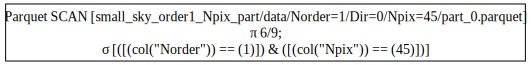

In [21]:
lazy_df_filtered = lazy_df.filter((pl.col('Norder') == 1) & (pl.col('Npix') == 45))
lazy_df_filtered.show_graph()

In [22]:
lazy_df_filtered.collect()

id,ra,dec,ra_error,dec_error,Norder,Dir,Npix,_healpix_29
i64,f64,f64,i64,i64,u8,u64,u64,i64
812,346.5,-60.5,0,0,1,0,45,3245124716102589287
722,350.5,-58.5,0,0,1,0,45,3246262717484375819
731,343.5,-52.5,0,0,1,0,45,3256317681613128823
720,344.5,-47.5,0,0,1,0,45,3257765200567140229
823,338.5,-45.5,0,0,1,0,45,3260117115293246469
…,…,…,…,…,…,…,…,…
705,335.5,-32.5,0,0,1,0,45,3300775760909901001
779,347.5,-29.5,0,0,1,0,45,3302771647141634889
761,329.5,-29.5,0,0,1,0,45,3308757303244427140


We can easily read the parquet schema from the `_common_metadata` directly:

In [23]:
pl.read_parquet_schema(f"{small_sky_order1_Npix_part_path}/data/_common_metadata")

{'id': Int64,
 'ra': Float64,
 'dec': Float64,
 'ra_error': Int64,
 'dec_error': Int64,
 'Norder': UInt8,
 'Dir': UInt64,
 'Npix': UInt64,
 '_healpix_29': Int64}

Filtering on non-hive partitioning keys works too:

In [24]:
lazy_df_filtered = lazy_df.filter((pl.col("ra") < 320) & (pl.col("dec") > -30))
lazy_df_filtered

In [25]:
lazy_df_filtered.collect()

id,ra,dec,ra_error,dec_error,Norder,Dir,Npix,_healpix_29
i64,f64,f64,i64,i64,u8,u64,u64,i64
770,285.5,-29.5,0,0,1,0,46,3380458994856416389
806,312.5,-29.5,0,0,1,0,47,3397704562975227384
791,312.5,-28.5,0,0,1,0,47,3397804200316730633
824,305.5,-28.5,0,0,1,0,47,3399000453069933430
702,310.5,-27.5,0,0,1,0,47,3399532867186255393
767,314.5,-29.5,0,0,1,0,47,3400255793565258227
743,307.5,-25.5,0,0,1,0,47,3424180623569024089


Polars does not support reading from HTTPS directly, but it's possible through pyarrow.

In [26]:
lazy_df = pl.scan_pyarrow_dataset(
    pds.parquet_dataset(
        metadata_path=f"{erosita_https_path}/data/_metadata",
        partitioning='hive',
        filesystem=https_fs,
        schema=pq.read_metadata(f"{erosita_https_path}/data/_common_metadata", filesystem=https_fs).schema.to_arrow_schema()
    )
)
lazy_df.collect_schema()

Schema([('IAUNAME', Binary),
        ('DETUID', Binary),
        ('SKYTILE', Int32),
        ('ID_SRC', Int32),
        ('UID', Int64),
        ('UID_Hard', Int64),
        ('ID_CLUSTER', Int32),
        ('RA', Float64),
        ('DEC', Float64),
        ('RA_RAW', Float64),
        ('DEC_RAW', Float64),
        ('RA_LOWERR', Float32),
        ('RA_UPERR', Float32),
        ('DEC_LOWERR', Float32),
        ('DEC_UPERR', Float32),
        ('POS_ERR', Float32),
        ('RADEC_ERR', Float32),
        ('LII', Float64),
        ('BII', Float64),
        ('ELON', Float64),
        ('ELAT', Float64),
        ('MJD', Float32),
        ('MJD_MIN', Float32),
        ('MJD_MAX', Float32),
        ('EXT', Float32),
        ('EXT_ERR', Float32),
        ('EXT_LOWERR', Float32),
        ('EXT_UPERR', Float32),
        ('EXT_LIKE', Float32),
        ('DET_LIKE_0', Float32),
        ('ML_CTS_1', Float32),
        ('ML_CTS_ERR_1', Float32),
        ('ML_CTS_LOWERR_1', Float32),
        ('ML_CTS_UPERR_

In [27]:
lazy_df.head(10).collect()

IAUNAME,DETUID,SKYTILE,ID_SRC,UID,UID_Hard,ID_CLUSTER,RA,DEC,RA_RAW,DEC_RAW,RA_LOWERR,RA_UPERR,DEC_LOWERR,DEC_UPERR,POS_ERR,RADEC_ERR,LII,BII,ELON,ELAT,MJD,MJD_MIN,MJD_MAX,EXT,EXT_ERR,EXT_LOWERR,EXT_UPERR,EXT_LIKE,DET_LIKE_0,ML_CTS_1,ML_CTS_ERR_1,ML_CTS_LOWERR_1,ML_CTS_UPERR_1,ML_RATE_1,ML_RATE_ERR_1,ML_RATE_LOWERR_1,…,ML_CTS_P9,ML_CTS_ERR_P9,ML_CTS_LOWERR_P9,ML_CTS_UPERR_P9,ML_RATE_P9,ML_RATE_ERR_P9,ML_RATE_LOWERR_P9,ML_RATE_UPERR_P9,ML_FLUX_P9,ML_FLUX_ERR_P9,ML_FLUX_LOWERR_P9,ML_FLUX_UPERR_P9,ML_BKG_P9,ML_EXP_P9,ML_EEF_P9,APE_CTS_P9,APE_BKG_P9,APE_EXP_P9,APE_RADIUS_P9,APE_POIS_P9,APE_CTS_S,APE_BKG_S,APE_EXP_S,APE_POIS_S,FLAG_SP_SNR,FLAG_SP_BPS,FLAG_SP_SCL,FLAG_SP_LGA,FLAG_SP_GC_CONS,FLAG_NO_RADEC_ERR,FLAG_NO_EXT_ERR,FLAG_NO_CTS_ERR,FLAG_OPT,Norder,Dir,Npix,_hipscat_index
binary,binary,i32,i32,i64,i64,i32,f64,f64,f64,f64,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i32,f32,f32,f32,f32,i32,f32,f32,f64,i16,i16,i16,i16,i16,i16,i16,i16,i16,u8,u64,u64,u64
"b""1eRASS\x20J085959.7+000035""","b""em01_134090_020_ML00540_011_c010""",134090,540,113409000540,0,529,134.999113,0.009725,134.999168,0.00984,4.54859,5.182195,5.339408,6.595008,5.619934,6.880704,228.909108,28.264411,137.45998,-16.326724,58975.574219,58975.242188,58975.910156,0.0,0.0,0.0,0.0,0.0,6.555671,5.689827,2.767465,2.396137,3.138793,0.069233,0.033674,0.029156,…,0.0,0.723164,0.0,0.723164,0.0,0.020655,0.0,0.020655,0.0,1.6724e-12,0.0,1.6724e-12,0.051279,35.012245,0.700575,0,0.130828,35.01532,13.546369,null,3,0.262145,83.23597,0.00247,0,0,0,0,0,0,0,0,0,0,0,1,1152921544851193856
"b""1eRASS\x20J090014.0+001034""","b""em01_137090_020_ML00138_011_c010""",137090,138,113709000138,0,128,135.058359,0.176284,135.058414,0.176399,4.025144,5.855574,3.690052,3.74832,5.704322,6.986722,228.781961,28.401257,137.46813,-16.150115,58975.574219,58975.242188,58975.910156,0.0,0.0,0.0,0.0,0.0,11.418695,7.427594,3.053057,2.666513,3.439601,0.090364,0.037144,0.032441,…,0.0,0.723164,0.0,0.723164,0.0,0.020687,0.0,0.020687,0.0,1.6751e-12,0.0,1.6751e-12,0.051507,34.95705,0.700575,0,0.130955,34.960888,13.488726,null,5,0.259637,83.213943,0.000008,0,0,0,0,0,0,0,0,0,0,0,1,1152929794376073216
"b""1eRASS\x20J085911.1+001550""","b""em01_134090_020_ML00309_011_c010""",134090,309,113409000309,0,298,134.796373,0.263944,134.796428,0.264059,7.251867,8.945492,5.389285,5.244814,9.277672,11.453262,228.543149,28.222045,137.180623,-16.142904,58975.410156,58975.074219,58975.742188,0.0,0.0,0.0,0.0,0.0,6.985588,5.130023,2.521857,2.154346,2.889368,0.066339,0.032611,0.027859,…,0.0,0.725213,0.0,0.725213,0.0,0.022033,0.0,0.022033,0.0,1.7841e-12,0.0,1.7841e-12,0.047251,32.914112,0.700575,0,0.118656,32.915127,13.385706,null,3,0.243051,78.329216,0.001996,0,0,0,0,0,0,0,0,0,0,0,1,1152960708141383680
"b""1eRASS\x20J085926.3+001615""","b""em01_134090_020_ML00183_011_c010""",134090,183,113409000183,0,174,134.859983,0.270977,134.860038,0.271092,3.983276,4.261491,3.943294,4.13885,4.78563,5.82993,228.573505,28.280188,137.241817,-16.117609,58975.410156,58975.074219,58975.742188,0.0,0.0,0.0,0.0,0.0,10.072052,4.913245,2.343414,1.98125,2.705578,0.062458,0.02979,0.025186,…,0.0,1.45963,0.0,1.45963,0.0,0.043201,0.0,0.043201,0.0,3.4980e-12,0.0,3.4980e-12,0.048291,33.787346,0.700575,1,0.119669,33.766979,13.406981,0.112786,2,0.246547,79.690727,0.02583,0,0,0,0,0,0,0,0,0,0,0,1,1152963332328652800
"b""1eRASS\x20J090150.1+003052""","b""em01_137090_020_ML00214_011_c010""",137090,214,113709000214,0,202,135.458883,0.514596,135.458939,0.514712,5.380714,5.952935,4.457843,4.834498,6.523555,8.0141,228.687473,28.91894,137.762886,-15.709055,58975.910156,58975.574219,58976.242188,0.0,0.0,0.0,0.0,0.0,8.130875,5.308729,2.614619,2.222216,3.007022,0.06146,0.03027,0.025727,…,0.0,1.242643,0.0,1.242643,0.0,0.034404,0.0,0.034404,0.0,2.7858e-12,0.0,2.7858e-12,0.05243,36.118916,0.700575,1,0.126405,36.160118,13.142291,0.118742,3,0.257699,87.322868,0.002354